In [1]:
!pip install torchmetrics[image]
!pip install gdown

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as T
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.backends.cudnn.benchmarks = True

import random
import numpy as np
import os
import torchvision
from torchvision.utils import save_image
from scipy.stats import truncnorm

import torchinfo
import os, shutil
import zipfile
import gdown
import matplotlib.pyplot as plt
import math

2024-05-28 23:22:19.536148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 23:22:19.536285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 23:22:19.665696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class GANOptions:
    def __init__(self, image_size=64, latent_dim=128, batch_size=32, n_epochs=10, data_path="", output_path="") -> None:
        self.num_epochs = n_epochs
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.label_softness = 0.1
        self.num_classes = 20

        self.data_path = data_path
        self.image_size = image_size
        self.img_ch = 3

        self.output_path = output_path
        self.save_interval = 100
        self.fid_interval = 100
        self.save_checkpoint = True
        self.load_checkpoint = False

        self.generator_frequency = 1
        self.generator_bn = True
        self.generator_lr = 2e-4
        self.generator_beta1 = 0.5
        self.generator_beta2 = 0.999
        self.weight_decay = 2.5e-5

        self.discriminator_frequency = 1
        self.discriminator_bn = True
        self.discriminator_lr = 2e-4
        self.discriminator_beta1 = 0.5
        self.discriminator_beta2 = 0.999
        self.discriminator_kernel = 5
        

In [4]:

def gan_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#GAN generator
class Generator(torch.nn.Module):

    def __init__(self, latent_dim, image_size, channels_nbr = 3, features_nbr = 64, dropout = 0.2, batch_norm = True, num_classes=10):
        super(Generator, self).__init__()
        
        layers = []

        #Compute model size
        in_features = latent_dim
        num_blocks = round(math.log2(image_size)) - 3
        out_features = features_nbr * (2 ** num_blocks)
        
        embedding_dim = 128
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        
        #First expansion layer (to 4x4 size)
        layers += [
            torch.nn.ConvTranspose2d(in_channels=in_features + embedding_dim, out_channels=out_features, kernel_size=4, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) if batch_norm else None,
            torch.nn.LeakyReLU(0.1, inplace=True)
        ]
        in_features = out_features
        out_features = out_features // 2
        
        #Transpose convolution blocks
        for i in range(num_blocks):
            layers += [
                torch.nn.Upsample(scale_factor=2),
                torch.nn.ReflectionPad2d(1),
                torch.nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, stride=1, padding=0),
                torch.nn.Dropout2d(p=0.3, inplace=True) if dropout > 0 else None,
                torch.nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) if batch_norm else None,
                torch.nn.InstanceNorm2d(out_features) if (not batch_norm) else None,
                torch.nn.LeakyReLU(0.1, inplace=True)
            ]
            in_features = out_features
            out_features = out_features // 2
        
        #Last conversion layer
        layers += [
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ReflectionPad2d(1),
            torch.nn.Conv2d(in_channels=in_features, out_channels=channels_nbr, kernel_size=3, stride=1, padding=0), 
            torch.nn.Tanh()
        ]
        
        #create sequential nn from layers list
        self.net = torch.nn.Sequential(*filter(lambda x: x is not None, layers))


    def forward(self, x, y):
        embed = self.embedding(y).unsqueeze(-1).unsqueeze(-1)
        x = torch.cat([x, embed], dim=1)
        return self.net(x)

#GAN discriminator
class Discriminator(torch.nn.Module):

    def __init__(self, image_size, channels_nbr = 3, features_nbr = 64, kernel_size = 5, dropout = 0.2, batch_norm = True,
                num_classes=10):
        super(Discriminator, self).__init__()
        
        layers = []
        
        #Compute model size
        in_features = channels_nbr
        out_features = features_nbr
        num_blocks = round(math.log2(image_size)) - 3
        
        layers += [
            torch.nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel_size, stride=2, padding=(kernel_size-1)//2, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True)
        ]
        in_features = out_features
        out_features *= 2
        
        for i in range(num_blocks):
            layers += [
                torch.nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel_size, stride=2, padding=(kernel_size-1)//2, bias=False),
                torch.nn.Dropout2d(p=0.3, inplace=True) if dropout > 0 else None,
                torch.nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) if batch_norm else None,
                torch.nn.InstanceNorm2d(out_features) if (not batch_norm) else None,
                torch.nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features *= 2
        
        self.num_classes = num_classes
        self.linear = nn.Linear(in_features, 1)
        self.embedding = nn.Embedding(self.num_classes, in_features)
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        
        #create sequential nn from layers list
        self.net = torch.nn.Sequential(*filter(lambda x: x is not None, layers))

    def forward(self, x, y):
        x = self.net(x)
        
        x = torch.sum(x, (2, 3))
        
        out = self.linear(x)
        shape = y.shape
        if len(shape) == 1:
            embed = self.embedding(y)
        else:
            y = y.type(self.embedding.weight.data.dtype)
            embed = y.matmul(self.embedding.weight.data)

        proj = torch.sum(embed * x, dim=1, keepdim=True)
        out = out + proj
        return out


In [5]:
z = torch.randn(16, 128, 1, 1).to(device)

y = torch.randint(0, 10, size=(16,)).to(device)

gen = Generator(128, 64).to(device)

fake1  = gen(z, y)
print(fake1.shape)

torchinfo.summary(gen, input_data=(z, y), col_names = ("input_size", "output_size", "num_params"))

torch.Size([16, 3, 64, 64])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Generator                                [16, 128, 1, 1]           [16, 3, 64, 64]           --
├─Embedding: 1-1                         [16]                      [16, 128]                 1,280
├─Sequential: 1-2                        [16, 256, 1, 1]           [16, 3, 64, 64]           --
│    └─ConvTranspose2d: 2-1              [16, 256, 1, 1]           [16, 512, 4, 4]           2,097,152
│    └─BatchNorm2d: 2-2                  [16, 512, 4, 4]           [16, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-3                    [16, 512, 4, 4]           [16, 512, 4, 4]           --
│    └─Upsample: 2-4                     [16, 512, 4, 4]           [16, 512, 8, 8]           --
│    └─ReflectionPad2d: 2-5              [16, 512, 8, 8]           [16, 512, 10, 10]         --
│    └─Conv2d: 2-6                       [16, 512, 10, 10]         [16, 256, 8, 8]           1,179,904
│    └─Dropout2

In [6]:
disc = Discriminator(64).to(device)

fake_pred = disc(fake1, y)

torchinfo.summary(disc, input_data=(fake1, y), col_names = ("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Discriminator                            [16, 3, 64, 64]           [16, 1]                   --
├─Sequential: 1-1                        [16, 3, 64, 64]           [16, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [16, 3, 64, 64]           [16, 64, 32, 32]          4,800
│    └─LeakyReLU: 2-2                    [16, 64, 32, 32]          [16, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [16, 64, 32, 32]          [16, 128, 16, 16]         204,800
│    └─Dropout2d: 2-4                    [16, 128, 16, 16]         [16, 128, 16, 16]         --
│    └─BatchNorm2d: 2-5                  [16, 128, 16, 16]         [16, 128, 16, 16]         256
│    └─LeakyReLU: 2-6                    [16, 128, 16, 16]         [16, 128, 16, 16]         --
│    └─Conv2d: 2-7                       [16, 128, 16, 16]         [16, 256, 8, 8]           819,200
│    └─Dropout2d: 2-8

In [7]:
def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred).mean()
    fake_loss = F.softplus(fake_pred).mean()
    return real_loss + fake_loss

def g_nonsaturation_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()
    return loss

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

    
def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool

def gan_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def interpolate(batch):
    return F.interpolate(batch, (299, 299), mode="bilinear")


def g_wgan_loss(pred_fake: torch.Tensor):
    fake_loss = - torch.mean(pred_fake)
    return fake_loss

def d_wgan_loss(pred_real: torch.Tensor, pred_fake: torch.Tensor):
    real_loss = torch.mean(pred_real)
    fake_loss = torch.mean(pred_fake)
    return fake_loss - real_loss


# clear folder
def clear_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


# make archieve
def make_zip(
        output_filename = "/kaggle/working/images28",
        dir_name = "/kaggle/working/images"
):
    shutil.make_archive(output_filename, 'zip', dir_name)

def unzip_file(
        file="/kaggle/working/game_scenes.zip",
        path_to_unzip="/kaggle/working/"
):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall(path_to_unzip)
    zip_ref.close()

# download from gdrive
def download_from_drive(
    url = "https://drive.google.com/us?id=17Z7_Fli_vgYuxO8JUoZICCiihG0sXYEY",
    output = "game_scenes.zip"
):
    # 2d_game_scenes.zip
    # https://drive.google.com/file/d/17Z7_Fli_vgYuxO8JUoZICCiihG0sXYEY/view?usp=drive_link

    gdown.download(url, output, quiet=False, fuzzy=True)


def remove(path):
    os.remove(path)


# utils
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, fid, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)
    writer.add_scalar("Loss Generator", loss_gen, global_step=tensorboard_step)
    writer.add_scalar("FID", fid, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, z_dim, labels, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, z_dim, 1, 1)), device=device, dtype=torch.float32)
            img = gen(noise)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

In [8]:
url_abstract = "https://drive.google.com/file/d/1o7tUq4-1dk_QRTJ27NGXoHElf3r1eCbc/view?usp=drive_link"

download_from_drive(
    url="https://drive.google.com/file/d/1Ub7LGj-3iXdLDIHp49Qz0Uhj7H29g3_L/view?usp=sharing",
   output="kth.zip")

unzip_file("/kaggle/working/kth.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1Ub7LGj-3iXdLDIHp49Qz0Uhj7H29g3_L
From (redirected): https://drive.google.com/uc?id=1Ub7LGj-3iXdLDIHp49Qz0Uhj7H29g3_L&confirm=t&uuid=6d67387d-b708-43b0-b2ae-100520308f3d
To: /kaggle/working/kth.zip
100%|██████████| 2.95G/2.95G [00:17<00:00, 168MB/s] 


In [9]:
remove("/kaggle/working/kth.zip")

In [10]:
seed_everything(1000)

In [11]:
# augmenatation

def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

policy = 'color,translation,cutout'

In [12]:
steps = []
fids_steps = []
d_losses = []
g_losses = []
fids = []

def clear_lists():
    steps.clear()
    fids_steps.clear()
    d_losses.clear()
    g_losses.clear()
    fids.clear()

In [34]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, img_ends='.jpg', text_transform=None, image_transform=None):
        self.root_dir = root_dir

        self.dataset = ImageFolder(root_dir, 
                               transform=image_transform)
        
        self.classes = []

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]

        return image[0], torch.tensor(idx // 10, dtype=torch.long)

In [13]:
class DCGAN:
    def __init__(self, options: GANOptions) -> None:
        self.G = Generator(options.latent_dim, options.image_size, num_classes=options.num_classes).to(device)

        self.D = Discriminator(options.image_size, num_classes=options.num_classes).to(device)

        self.options = options

    def get_dataloaders(self):
        IMG_SIZE = self.options.image_size
        
        data_transform = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #         
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )
        
        dataset = ImageFolder(root=self.options.data_path, transform=data_transform)
#         dataset = ImageDataset(root_dir=self.options.data_path, image_transform=data_transform)
        loader = DataLoader(
            dataset,
            batch_size=self.options.batch_size,
            shuffle=True,
            drop_last=True
        )
        test_dataset = torch.utils.data.Subset(dataset, torch.arange(3000))


        test_dataloader = DataLoader(
            test_dataset,
            batch_size=self.options.batch_size,
            shuffle=True,
            drop_last=True
        )

        train_num_classes = len(dataset.classes)

        return [loader, iter(cycle(test_dataloader))], []
    
    def get_optimizers(self):
        opt_gen = optim.Adam(self.G.parameters(), 
                             lr=self.options.generator_lr, 
                             betas=(self.options.generator_beta1, self.options.generator_beta2), 
                             weight_decay=self.options.weight_decay)
        
        opt_disc = optim.Adam(self.D.parameters(), 
                              betas=(self.options.generator_beta1, self.options.generator_beta2), 
                              weight_decay=self.options.weight_decay)
        
        return [opt_gen, opt_disc]

    def save(self, path, name=""):
        torch.save(self.G.state_dict(), f"{path}/generator{name}.model")
        torch.save(self.D.state_dict(), f"{path}/discriminator{name}.model")

    def load(self, path, name=""):
        self.G.load_state_dict(torch.load(f"{path}/generator{name}.model"))
        self.D.load_state_dict(torch.load(f"{path}/discriminator{name}.model"))

        self.G.eval()
        self.D.eval()

    def save_checkpoint(self):
        ...

    def load_checkpoint(self):
        ...

    def train(self):
        
        os.makedirs('%s/images' % self.options.output_path, exist_ok=True)
        os.makedirs('%s/models' % self.options.output_path, exist_ok=True)

        if self.weights_init:
            
            gain = 2 ** 0.5
            xavier = False
        
            for module in self.G.modules():
                if xavier:
                
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.xavier_uniform_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                else:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.normal_(module.weight, 0.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                    if (isinstance(module, nn.BatchNorm2d)):
                        nn.init.normal_(module.weight, 1.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
            
            for module in self.D.modules():
                
                if xavier:
                
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.xavier_uniform_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                else:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.normal_(module.weight, 0.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                    if (isinstance(module, nn.BatchNorm2d)):
                        nn.init.normal_(module.weight, 1.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
        
#             self.G.apply(gan_weights_init)
#             self.D.apply(gan_weights_init)

        [train_dataloader, dataiter],[] = self.get_dataloaders()

        criterion = nn.BCEWithLogitsLoss()
        
        self.save_interval = len(train_dataloader) // 1
        
        self.fid_interval = len(train_dataloader) // 5
        
        opt_gen, opt_disc = self.get_optimizers()

        fixed_noise = torch.randn(8, self.options.latent_dim, 1, 1).to(device)
        fixed_labels = torch.arange(start=0, end=8, dtype=torch.long, device=device) % self.options.num_classes

        scaler = torch.cuda.amp.GradScaler()
        
        fid = FrechetInceptionDistance(feature=192, normalize=True).to(device)
        
        fid_value = torch.zeros(1).to(device)

        update_progress_bar = 2
        
        step = 0

        writer = SummaryWriter(self.options.output_path+"/logs")

        for epoch in range(self.options.num_epochs):
            loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
            real: torch.Tensor
            for batch_idx, (real, labels) in loop:

                opt_disc.zero_grad()
                    
                with torch.cuda.amp.autocast():
                    real = real.to(device)
                    labels = labels.to(device)
                    
                    real_pred = self.D(DiffAugment(real, policy), labels)

                    real_labels = torch.empty_like(real_pred).uniform_(1-self.options.label_softness, 1)

                    real_loss =  criterion(real_pred, real_labels)

                    # --- #
                    noise = torch.randn(self.options.batch_size, self.options.latent_dim, 1, 1).to(device)
                    fake = self.G(noise, labels)

                    fake_pred = self.D(DiffAugment(fake, policy), labels)

                    fake_labels = torch.empty_like(fake_pred).uniform_(0.0, self.options.label_softness)

                    fake_loss = criterion(fake_pred, fake_labels)

                    lossD = (real_loss+fake_loss)/2

                    d_losses.append(lossD.item())

                scaler.scale(lossD).backward()
    
                scaler.step(opt_disc)

                scaler.update()

                opt_gen.zero_grad()
                with torch.cuda.amp.autocast():
                    noise = torch.randn(self.options.batch_size, self.options.latent_dim, 1, 1).to(device)
                    fake = self.G(noise, labels)
                    
                    output = self.D(DiffAugment(fake, policy), labels)
                    real_labels = torch.ones_like(output)
                    gen_loss = criterion(output, real_labels)
                    
                    g_losses.append(gen_loss.item())

                    scaler.scale(gen_loss).backward()
                    scaler.step(opt_gen)
                    scaler.update()

                if (step+1) % self.fid_interval == 0:
                    real, labels = next(dataiter)

                    with torch.cuda.amp.autocast():
                        real = real.to(device)
                        labels = labels.to(device)

                        noise = torch.randn(self.options.batch_size, self.options.latent_dim, 1, 1).to(device)
                        fake = self.G(noise, labels)
                        
                        fake1 = fake.detach() * 0.5 + 0.5 

                        grid = vutils.make_grid(fake1, nrow=self.options.batch_size//4, normalize=True)
                
                        vutils.save_image(grid, f"{self.options.output_path}/images/{epoch}-{batch_idx}.jpg")
                            
                        real = interpolate(real)
                        fake = interpolate(fake)

                        fid.update(real, real=True)
                        fid.update(fake, real=False)
                        fid_value = fid.compute()
                        
                        fids.append(fid_value.item())
                        fids_steps.append(step+1)
                        fid.reset()
                
#                 with torch.no_grad():
#                         with torch.cuda.amp.autocast():
#                             fixed_fakes = self.G(fixed_noise, fixed_labels)

#                 plot_to_tensorboard(
#                         writer,
#                         lossD.item(),
#                         gen_loss.item(),
#                         fid_value.item(),
#                         real.detach(),
#                         fixed_fakes.detach(),
#                         step
#                     )

                step+=1
                steps.append(step)
                # update progress bar
                if batch_idx % update_progress_bar == 0:
                    loop.set_description(f"Epoch [{epoch}/{self.options.num_epochs}]")
                    loop.set_postfix(loss_g = gen_loss.item(), loss_d = lossD.item(), fid = fid_value.item() )
            self.save(self.options.output_path + "/models/")

In [ ]:
clear_lists()
# clear_folder("/kaggle/working/logs")
# clear_folder("/kaggle/working/images")
options = GANOptions(
    n_epochs=20,
    data_path="/kaggle/working/2d_game_scenes",
    output_path="/kaggle/working/",
    image_size=64,
    batch_size=32,
)
options.generator_lr = 2e-4
options.generator_beta1 = 0.5
options.discriminator_lr = 2e-4
options.discriminator_beta1 = 0.5
options.label_softness = 0.1
options.num_classes = 20


dcgan = DCGAN(options)
dcgan.weights_init = True
# dcgan.load(options.output_path + "/models/")

dcgan.train()

dcgan.save(options.output_path + "/models/")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 255MB/s] 
  0%|          | 0/1875 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Epoch [2/20]:  68%|██████▊   | 1268/1875 [04:23<02:09,  4.67it/s, fid=75.9, loss_d=0.6

In [29]:
make_zip(
    output_filename = "/kaggle/working/images_dcgan",
    dir_name = "/kaggle/working/images"
)

In [16]:
[train_dataloader, dataiter],[] = dcgan.get_dataloaders()

fid = FrechetInceptionDistance(feature=192, normalize=True).to(device)

fid_values = []

for i in range(10):

    real, labels = next(dataiter)

    with torch.cuda.amp.autocast():
        real = real.to(device)
        labels = labels.to(device)

        noise = torch.randn(options.batch_size, options.latent_dim, 1, 1).to(device)
        fake = dcgan.G(noise, labels)

        real = interpolate(real)
        fake = interpolate(fake)

        fid.update(real, real=True)
        fid.update(fake, real=False)
        fid_value = fid.compute()
        fid_values.append(fid_value.item())
        fid.reset()
        

fid_values = np.array(fid_values)

print(np.mean(fid_values))

19.203125


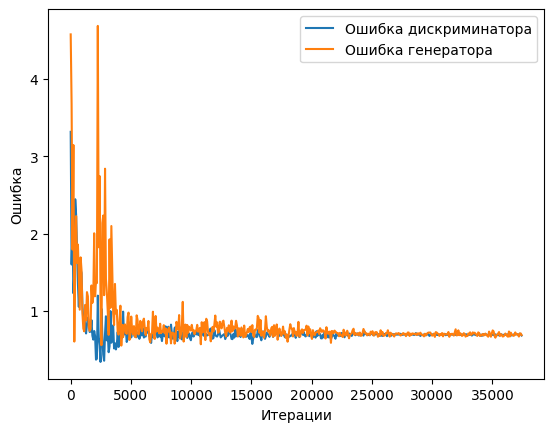

In [28]:
plt.xlabel("Итерации")
plt.ylabel("Ошибка")
plt.plot(steps[0::75], d_losses[0::75], label="Ошибка дискриминатора")
plt.plot(steps[0::75], g_losses[0::75], label="Ошибка генератора")
plt.legend()
plt.savefig("/kaggle/working/d_g__losses.png")
plt.show()

In [22]:
print(np.mean(d_losses))
print(np.mean(g_losses))

0.7174641905693213
0.811890445442597


100
100


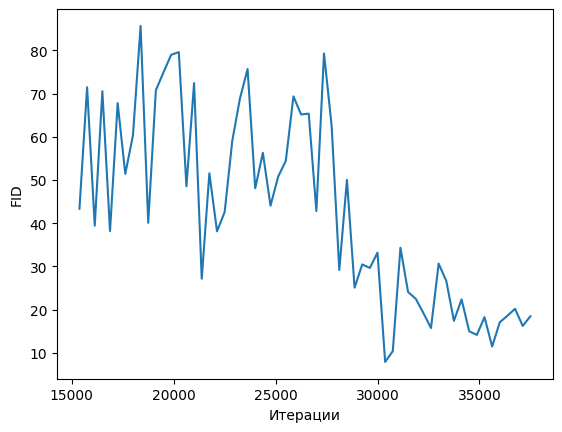

In [25]:
# LOG_FID_INTERVAL+1
# steps_fids = steps[::dcgan.fid_interval]
# print(len(steps_fids))
print(len(fids))
print(len(fids_steps))

plt.xlabel("Итерации")
plt.ylabel("FID")
plt.plot(fids_steps[40::], fids[40::])
# plt.legend()
plt.savefig("/kaggle/working/fid.png")
plt.show()